In [513]:
""" This module prepares midi file data and feeds it to the neural
    network for training """
import glob
import pickle
import numpy
from music21 import converter, instrument, note, chord
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import BatchNormalization as BatchNorm
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

def note_duration(notes_test):
    notes_formated = []
    for y in notes_test:
        notes_formated.append("_".join(y))
    return notes_formated
        
def get_formated_data():
    """ Train a Neural Network to generate music """
    notes = get_notes_v2()
  
    
    notes_formated= note_duration(notes)
    # get amount of pitch names
    n_vocab = len(set(notes_formated))
    
    network_input, network_output = prepare_sequences(notes_formated, n_vocab)
    
    return network_input, network_output ,n_vocab,notes_formated
    #model = create_network(network_input, n_vocab)
    
    #train(model, network_input, network_output)

    
def get_notes_v2():
    """ Get all the notes and chords from the midi files in the ./midi_songs directory """
    notes = []

    #for file in glob.glob("ff_midi/ff7tifa.mid"):
    for file in glob.glob("midi_songs/*.mid"):

        midi = converter.parse(file)

        print("Parsing %s" % file)

        notes_to_parse = None

        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi)
            #for i in range(0,len(s2.parts)):
             #   if s2.parts[i].partName == "Flute"
            #notes_to_parse = s2.parts[3].recurse()
            notes_to_parse = s2.parts[0].recurse() 

            print(notes_to_parse)
        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes

        for element in notes_to_parse[:]:
            
            if isinstance(element, note.Note):
                #print(element.pitch,element.seconds,element.duration)
                notes.append([str(element.pitch),str(element.duration).split()[1].replace(">",""),str(element.volume.velocity)])
            elif isinstance(element, chord.Chord):
                #print(('.'.join(str(n) for n in element.normalOrder)),"  ",element.seconds,"  ",element.duration)
                notes.append(['.'.join(str(n) for n in element.normalOrder),str(element.duration).split()[1].replace(">",""),str(element.volume.velocity)])
            #elif  isinstance(element, note.Rest):
                #print("SILENCE",element,element.seconds,element.duration)
            #else:
                #print("SILENCE____",element.seconds)

    with open('data/lofi_notes_velocity_V2', 'wb') as filepath:
    #with open('data/FF_notes_velocity', 'wb') as filepath:
        pickle.dump(notes, filepath)

    return notes

def prepare_sequences(notes, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    sequence_length = 32

    # get all pitch names
    pitchnames = sorted(set(item for item in notes))

     # create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    network_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    network_input = network_input / float(n_vocab)

    network_output = np_utils.to_categorical(network_output)

    return (network_input, network_output)

def create_network(network_input, n_vocab):
    """ create the structure of the neural network """
    model = Sequential()
    model.add(LSTM(
        512,
        input_shape=(network_input.shape[1], network_input.shape[2]),
        recurrent_dropout=0.3,
        return_sequences=True
    ))
    model.add(LSTM(512, return_sequences=True, recurrent_dropout=0.3,))
    model.add(LSTM(512))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    #model.load_weights('FF_Duration_aerith_model_checkpoint-103-2.0986.hdf5')
    #model.load_weights('FF_Duration_model_checkpoint-106-0.3691.hdf5')
    #model.load_weights('LoFi_Duration_model_checkpoint-116-0.1289.hdf5')
    #model.load_weights('FF_Duration_Velocity_model_checkpoint-150-0.7856.hdf5')
    model.load_weights('LoFi_Duration_Velocity_model_checkpoint-143-0.1727.hdf5')
    #model.load_weights('LoFi_Duration_Velocity_nochords_model_checkpoint-150-1.5498.hdf5')

    return model

def train(model, network_input, network_output):
    """ train the neural network """
    #filepath = "FF_Duration_Velocity_model_checkpoint-1{epoch:02d}-{loss:.4f}.hdf5"
    filepath = "LoFi_Duration_Velocity_model_checkpoint-1{epoch:02d}-{loss:.4f}.hdf5"

    checkpoint = ModelCheckpoint(
        filepath,
        monitor='loss',
        verbose=0,
        save_best_only=True,
        mode='min'
    )
    callbacks_list = [checkpoint]

    model.fit(network_input, network_output, epochs=50, batch_size=64, callbacks=callbacks_list)



In [514]:

network_input, network_output ,n_vocab,notes_formated = get_formated_data()



#train(model, network_input, network_output)

Parsing midi_songs/Piano MIDI (2).mid
<music21.stream.iterator.RecursiveIterator for Part:None @:0>
Parsing midi_songs/Cymatics - Lofi MIDI 15 - F# Maj.mid
<music21.stream.iterator.RecursiveIterator for Part:None @:0>
Parsing midi_songs/Rhodes MIDI (7).mid
<music21.stream.iterator.RecursiveIterator for Part:None @:0>
Parsing midi_songs/Cymatics - Eternity MIDI 11 - A Maj.mid
<music21.stream.iterator.RecursiveIterator for Part:None @:0>
Parsing midi_songs/Cymatics - Eternity MIDI 7 - E Min.mid
<music21.stream.iterator.RecursiveIterator for Part:None @:0>
Parsing midi_songs/Rhodes MIDI (6).mid
<music21.stream.iterator.RecursiveIterator for Part:None @:0>
Parsing midi_songs/Cymatics - Lofi MIDI 13 - E Min.mid
<music21.stream.iterator.RecursiveIterator for Part:None @:0>
Parsing midi_songs/Cymatics - Lofi MIDI 18 - G Maj.mid
<music21.stream.iterator.RecursiveIterator for Part:None @:0>
Parsing midi_songs/Cymatics - Lofi MIDI 3 - C# Min.mid
<music21.stream.iterator.RecursiveIterator for Par

In [515]:
network_input.shape


(1868, 32, 1)

In [516]:
n_vocab

1259

In [517]:
model = create_network(network_input, n_vocab)

#train(model, network_input, network_output)

In [498]:

train(model, network_input, network_output)

Epoch 1/50
17/17 [==============================] - 22s 927ms/step - loss: 1.8935
Epoch 2/50
17/17 [==============================] - 16s 956ms/step - loss: 1.5847
Epoch 3/50
17/17 [==============================] - 17s 988ms/step - loss: 1.4051
Epoch 4/50
17/17 [==============================] - 16s 964ms/step - loss: 1.3236
Epoch 5/50
17/17 [==============================] - 16s 966ms/step - loss: 1.1884
Epoch 6/50
17/17 [==============================] - 17s 971ms/step - loss: 1.1740
Epoch 7/50
17/17 [==============================] - 16s 960ms/step - loss: 1.1407
Epoch 8/50
17/17 [==============================] - 16s 941ms/step - loss: 1.0089
Epoch 9/50
17/17 [==============================] - 16s 942ms/step - loss: 0.8879
Epoch 10/50
17/17 [==============================] - 16s 934ms/step - loss: 0.8394
Epoch 11/50
17/17 [==============================] - 16s 943ms/step - loss: 0.7449
Epoch 12/50
17/17 [==============================] - 16s 915ms/step - loss: 0.7215
Epoch 13/50
1

In [499]:
n_vocab

695

In [518]:

""" This module generates notes for a midi file using the
    trained neural network """
import pickle
import numpy
from music21 import instrument, note, stream, chord
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import BatchNormalization as BatchNorm
from keras.layers import Activation
import music21
from fractions import Fraction

def generate(model):
    """ Generate a piano midi file """
    #load the notes used to train the model
    with open('data/lofi_notes_velocity_V2', 'rb') as filepath:
    #with open('data/lofi_notes_velocity', 'rb') as filepath:

        notes = pickle.load(filepath)
    notes= note_duration(notes)
    # Get all pitch names
    pitchnames = sorted(set(item for item in notes))
    # Get all pitch names
    n_vocab = len(set(notes))

    network_input, normalized_input = prepare_sequences_2(notes, pitchnames, n_vocab)
    model = model
    prediction_output = generate_notes(model, network_input, pitchnames, n_vocab)
    create_midi(prediction_output)
    return prediction_output

def prepare_sequences_2(notes, pitchnames, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    # map between notes and integers and back
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    sequence_length = 32
    network_input = []
    output = []
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    normalized_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    normalized_input = normalized_input / float(n_vocab)

    return (network_input, normalized_input)

""" def create_network(network_input, n_vocab):
    # create the structure of the neural network 
    model = Sequential()
    model.add(LSTM(
        512,
        input_shape=(network_input.shape[1], network_input.shape[2]),
        recurrent_dropout=0.3,
        return_sequences=True
    ))
    model.add(LSTM(512, return_sequences=True, recurrent_dropout=0.3,))
    model.add(LSTM(512))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # Load the weights to each node
    #model.load_weights('Fupdated-lofi-hip-hop-weights-improvement-100-0.6290.hdf5')

    return model"""

def generate_notes(model, network_input, pitchnames, n_vocab):
    """ Generate notes from the neural network based on a sequence of notes """
    # pick a random sequence from the input as a starting point for the prediction
    start = numpy.random.randint(0, len(network_input)-1)

    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    pattern = network_input[start]
    prediction_output = []

    # generate 200 notes
    for note_index in range(200):
        prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        index = numpy.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)

        pattern.append(index)
        pattern = pattern[1:len(pattern)]

    return prediction_output

def create_midi(prediction_output):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []
    
    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        pattern_note = pattern.split("_")[0]
        pattern_duration = pattern.split("_")[1]
        pattern_velocity = pattern.split("_")[2]
        if ('.' in pattern_note) or pattern_note.isdigit():
            notes_in_chord = pattern_note.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.duration = music21.duration.Duration((Fraction(pattern_duration).numerator/Fraction(pattern_duration).denominator))
                v = music21.volume.Volume(velocity=int(pattern_velocity))
                new_note.volume.velocity = v.velocity
                
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern_note)
            new_note.duration = music21.duration.Duration((Fraction(pattern_duration).numerator/Fraction(pattern_duration).denominator))
            v = music21.volume.Volume(velocity=int(pattern_velocity))
            new_note.volume.velocity = v.velocity
            new_note.offset = offset
 

            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += Fraction(pattern_duration).numerator/Fraction(pattern_duration).denominator

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp='lowfi_output30_velocity.mid')



In [519]:
#if __name__ == '__main__':
    #train_network()


In [520]:
output_prediction= generate(model)

In [521]:
output_prediction

['E3_0.25_94',
 'E-4_0.25_102',
 'E3_0.25_97',
 'G#4_0.25_96',
 'E3_0.25_99',
 'E-4_0.25_100',
 'E3_0.25_99',
 'G#4_0.25_96',
 '11.4_0.25_97',
 'E3_0.25_97',
 'G#4_0.25_81',
 '3.4_0.25_94',
 'E3_0.25_93',
 'G#4_0.25_95',
 '3.4_0.25_98',
 'E3_0.25_94',
 'G#4_0.25_91',
 'E3_0.25_95',
 '3.4_0.25_96',
 'G#4_0.25_94',
 'E3_0.25_99',
 '11.4_0.25_98',
 'G#4_0.25_79',
 'E3_0.25_93',
 'E-4_0.25_95',
 '4.8_0.25_92',
 'E3_0.25_95',
 '3.4_0.25_93',
 'G#4_0.25_89',
 'E3_0.25_94',
 '3.4_0.25_98',
 'G#4_0.25_98',
 'E3_0.25_95',
 '11.4_0.25_96',
 'G#4_0.25_94',
 'E3_0.25_94',
 '3.4_0.25_94',
 'G#4_0.25_92',
 'E3_0.25_90',
 '3.4_0.25_98',
 'G#4_0.25_95',
 'E3_0.25_90',
 '3.4_0.25_98',
 'G#4_0.25_95',
 'E3_0.25_96',
 'B4_0.25_102',
 'E3_0.25_99',
 '4.7.11_1/3_60',
 'E4_0.5_64',
 'G4_0.5_64',
 'E5_0.5_64',
 '6.9.11.2_1/3_59',
 'F#4_0.5_64',
 'F#5_0.5_64',
 'E5_0.5_64',
 'G5_0.5_64',
 'B5_0.5_64',
 '4.7.11_1/3_60',
 'E4_0.5_64',
 'G4_0.5_64',
 'E5_0.5_64',
 '6.9.11.2_1/3_59',
 'F#4_0.5_64',
 'F#5_0.5_64',

In [275]:
note_x = note.Note(output_prediction[5].split("_")[0])
note_y = notes_to_parse[:][3]

In [282]:
note_y.volume.velocity = v.velocity

In [283]:
note_y.volume.velocity

90

90

In [403]:
with open('data/lofi_notes_velocity_V2', 'rb') as filepath:
    notes = pickle.load(filepath)
notes= note_duration(notes)
    # Get all pitch names
pitchnames = sorted(set(item for item in notes))
    # Get all pitch names
n_vocab = len(set(notes))

network_input, normalized_input = prepare_sequences_2(notes, pitchnames, n_vocab)

note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

In [405]:
note_to_int

{'0.1.3.5.8_3.0_72': 0,
 '0.1.3.5.8_4.0_72': 1,
 '0.1.5.8_0.25_86': 2,
 '0.1.5.8_2.75_53': 3,
 '0.2.3.5.7_0.25_64': 4,
 '0.2.3.7_1.0_64': 5,
 '0.2.3.7_11/3_87': 6,
 '0.2.3.7_2.0_64': 7,
 '0.2.3.7_3.75_57': 8,
 '0.2.4.7.9_3.0_79': 9,
 '0.2.4.7_0.5_64': 10,
 '0.2.4_1.0_71': 11,
 '0.2.5_1.0_64': 12,
 '0.2_1.0_64': 13,
 '0.2_2.0_64': 14,
 '0.2_4.0_88': 15,
 '0.3.5.7.8_4.0_48': 16,
 '0.3.5.7.8_4.0_59': 17,
 '0.3.5.7.8_4/3_72': 18,
 '0.3.5.7.8_7/3_72': 19,
 '0.3.5.7_0.25_64': 20,
 '0.3.5.8_0.25_91': 21,
 '0.3.5.8_2.75_53': 22,
 '0.3.5.8_2.75_63': 23,
 '0.3.5.8_4/3_72': 24,
 '0.3.5_1.0_64': 25,
 '0.3.5_1.5_61': 26,
 '0.3.5_1.75_64': 27,
 '0.3.7_0.25_60': 28,
 '0.3.7_0.25_73': 29,
 '0.3.7_1.0_64': 30,
 '0.3.7_1.5_44': 31,
 '0.3.7_10/3_70': 32,
 '0.3.7_2.75_63': 33,
 '0.3.7_3.25_60': 34,
 '0.3.7_3.25_69': 35,
 '0.3_2/3_61': 36,
 '0.3_3.5_70': 37,
 '0.4.7_0.25_64': 38,
 '0.4.7_0.5_64': 39,
 '0.4.7_1.0_37': 40,
 '0.4.7_1.0_44': 41,
 '0.4.7_4.0_78': 42,
 '0.4_0.5_91': 43,
 '0.4_1.0_68': 44,
 '0.4_

In [152]:
sequence_length = 32
network_input = []
output = []
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    output.append(note_to_int[sequence_out])

n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
normalized_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))

## Using embeddings -  Model Version 2 ?

https://www.dropbox.com/sh/ttzb502hheo9fst/AABIlaxy09RRt2b316jcFwIga/LSTM?dl=0&preview=LSTM.py&subfolder_nav_tracking=1

In [419]:
import numpy as np


# prepare music data
def process_data(songs):
    whole_data = []
    for song in songs:
        midi_data = converter.parse(song).flat
        song_data = []
        prev_offset = -1
        for element in midi_data:
            if isinstance(element, note.Note):
                if element.offset != prev_offset:
                    song_data.append([element.pitch.nameWithOctave, 
                                      element.quarterLength])
                else:
                    if len(song_data[-1]) < 4:
                        song_data[-1].append(element.pitch.nameWithOctave)   
                        song_data[-1].append(element.quarterLength)       
                prev_offset = element.offset
            elif isinstance(element, chord.Chord):
                pitch_names = '.'.join(n.nameWithOctave for n in element.pitches)
                if element.offset != prev_offset:
                    song_data.append([pitch_names, element.quarterLength])
                else:
                    if len(song_data[-1]) < 4:
                        song_data[-1].append(pitch_names)   
                        song_data[-1].append(element.quarterLength)      
                prev_offset = element.offset
        for item in song_data:
            if len(item) < 4:
                item.append(None)
                item.append(None)
        whole_data.append(song_data)
    return whole_data

def transform_data(songs):
    max_len = 0
    for song in songs:
        max_len = max(max_len, len(song))
    for song in songs:
        for i in range(max_len - len(song)):
            song.append([None, None, None, None])
    transform_data = []
    for song in songs:
        t_song_data = []
        for item in song:
            t_song_data.append(tuple(item))
        transform_data.append(t_song_data)
    return transform_data


# get a dictionary of the unique notes
def get_dictionary(songs):
    possible_combs = set(item for song in songs for item in song)
    data_to_int = dict((v, i) for i, v in enumerate(possible_combs))
    int_to_data = dict((i, v) for i, v in enumerate(possible_combs))
    return data_to_int, int_to_data    

songs = glob.glob("midi_songs/*.mid")
songs_data = process_data(songs)
songs_data = transform_data(songs_data)
# # of songs (samples) x # of timestamps x tuple of 4 (combination of notes
# and rhythms of both hands)
print("Whole music data size:", np.array(songs_data).shape)
data_to_int, int_to_data = get_dictionary(songs_data)
print("Number of unique notes:", len(data_to_int))

Whole music data size: (93, 120, 4)
Number of unique notes: 830


In [413]:
data_to_int

{('B-3', 4.0, 'F4', Fraction(1, 6)): 0,
 ('B5', 1.25, None, None): 1,
 ('F2.D3.G3.D4', Fraction(10, 3), 'A4', 0.25): 2,
 ('B2.D3', Fraction(10, 3), None, None): 3,
 ('E-3.B-3.E-4.F#4.B-4', Fraction(1, 3), None, None): 4,
 ('G4.G3.B-4.D5.F5', 0.25, None, None): 5,
 ('B-3.B-4.D5', 0.25, None, None): 6,
 ('B-5', 0.25, None, None): 7,
 ('D2.D3.F3.A3.D4.F4', 0.25, None, None): 8,
 ('F#4', Fraction(1, 3), None, None): 9,
 ('F2.F3.E4.A3.C4', 1.25, None, None): 10,
 ('A3', 1.0, None, None): 11,
 ('F3', 0.5, None, None): 12,
 ('F3.F4.G#4.C5.F5.G#5', 1.0, None, None): 13,
 ('C2.C5.E-5.C3.E-3.G5.G3', 0.25, None, None): 14,
 ('G3.C4', 1.0, 'C5.A5', 1.0): 15,
 ('E-3.G3.C4.E-4.G4', 2.75, None, None): 16,
 ('G#2.F#3.B3.E-4.E-5', 2.0, None, None): 17,
 ('C5', 0.25, None, None): 18,
 ('G3.C4.E4.G4.B4', 3.25, None, None): 19,
 ('F4.B-3.G3.G2.D4', 0.25, None, None): 20,
 ('C3.B-3.C4.D4.E-4.G4', 3.75, None, None): 21,
 ('B2.E3.G3.B3', 1.25, 'D4', 1.75): 22,
 ('F5', 0.5, 'E-3', 1.0): 23,
 ('E6', 0.25, None

In [407]:
whole_notes= process_data(glob.glob("midi_songs/*.mid"))

In [410]:
whole_notes[0][0]

['E-3.E-2.G3.E-3.B-3.D4.G3', Fraction(2, 3), None, None]

In [420]:
INPUT = 100
HIDDEN = 256
vocab_size = len(data_to_int)
OUTPUT = vocab_size
LEARNING_RATE = 0.005
BETA1 = 0.9
BETA2 = 0.999
BATCH_SIZE = 50

# activation functions #######################################################
def sigmoid(X):
    return 1. / (1 + np.exp(-X))

def softmax(X):
    exp_X = np.exp(X)
    return exp_X / np.sum(exp_X, axis=1).reshape(-1, 1)

def tanh(X):
    return np.tanh(X)

def dtanh(X):
    return 1 - X**2

# LSTM #######################################################################
def initialize_parameters():
    parameters = {}
    parameters['fgw'] = np.random.normal(0,0.01,(INPUT+HIDDEN,HIDDEN))
    parameters['igw'] = np.random.normal(0,0.01,(INPUT+HIDDEN,HIDDEN))
    parameters['ogw'] = np.random.normal(0,0.01,(INPUT+HIDDEN,HIDDEN))
    parameters['ggw'] = np.random.normal(0,0.01,(INPUT+HIDDEN,HIDDEN))
    parameters['how'] = np.random.normal(0,0.01,(HIDDEN,OUTPUT)) 
    return parameters


def initialize_V(parameters):
    V = {}
    V['vfgw'] = np.zeros(parameters['fgw'].shape)
    V['vigw'] = np.zeros(parameters['igw'].shape)
    V['vogw'] = np.zeros(parameters['ogw'].shape)
    V['vggw'] = np.zeros(parameters['ggw'].shape)
    V['vhow'] = np.zeros(parameters['how'].shape)
    return V


def initialize_S(parameters):
    S = {}
    S['sfgw'] = np.zeros(parameters['fgw'].shape)
    S['sigw'] = np.zeros(parameters['igw'].shape)
    S['sogw'] = np.zeros(parameters['ogw'].shape)
    S['sggw'] = np.zeros(parameters['ggw'].shape)
    S['show'] = np.zeros(parameters['how'].shape)
    return S


def get_embeddings(batch_dataset, embeddings):
    embedding_dataset = np.matmul(batch_dataset, embeddings)
    return embedding_dataset


def lstm_cell(batch_dataset, prev_activation_matrix, prev_cell_matrix, parameters):
    concat_dataset = np.concatenate((batch_dataset, prev_activation_matrix), axis=1)
    fa = sigmoid(np.matmul(concat_dataset, parameters['fgw']))
    ia = sigmoid(np.matmul(concat_dataset, parameters['igw']))
    oa = sigmoid(np.matmul(concat_dataset, parameters['ogw']))
    ga = tanh(np.matmul(concat_dataset, parameters['ggw']))
    cell_memory_matrix = np.multiply(fa, prev_cell_matrix) + np.multiply(ia, ga)
    activation_matrix = np.multiply(oa, tanh(cell_memory_matrix))
    lstm_activations = {}
    lstm_activations['fa'] = fa
    lstm_activations['ia'] = ia
    lstm_activations['oa'] = oa
    lstm_activations['ga'] = ga
    return lstm_activations,cell_memory_matrix,activation_matrix


def output_cell(activation_matrix, parameters):
    output_matrix = softmax(np.matmul(activation_matrix, parameters['how'])) 
    return output_matrix


def cal_loss_accuracy(batch_labels, output_cache):
    loss, accuracy, prob = 0, 0, 1
    batch_size = batch_labels[0].shape[0]
    for i in range(1, len(output_cache)+1):
        labels = batch_labels[i]
        pred = output_cache['o' + str(i)]
        prob = np.multiply(prob, np.sum(np.multiply(labels, pred), axis=1).reshape(-1, 1))
        loss += np.sum((np.multiply(labels, np.log(pred)) + np.multiply(1-labels, np.log(1-pred))), axis=1).reshape(-1, 1)
        accuracy += np.array(np.argmax(labels, 1) == np.argmax(pred, 1), dtype=np.float32).reshape(-1, 1)
    perplexity = np.sum((1 / prob)**(1 / len(output_cache))) / batch_size
    loss = np.sum(loss) * (-1 / batch_size)
    accuracy = (np.sum(accuracy) / (batch_size)) / len(output_cache)
    
    return perplexity, loss, accuracy
    

def forward_propagation(batches, parameters, embeddings):
    batch_size = batches[0].shape[0]
    lstm_cache, activation_cache, cell_cache = {}, {}, {}
    output_cache, embedding_cache = {}, {}
    a0 = np.zeros([batch_size, HIDDEN], dtype=np.float32)
    c0 = np.zeros([batch_size, HIDDEN], dtype=np.float32)
    activation_cache['a0'] = a0
    cell_cache['c0'] = c0
    for i in range(len(batches) - 1):
        batch_dataset = batches[i]
        batch_dataset = get_embeddings(batch_dataset, embeddings)
        embedding_cache['emb' + str(i)] = batch_dataset
        lstm_activations, ct, at = lstm_cell(batch_dataset, a0, c0, parameters)
        ot = output_cell(at, parameters)
        lstm_cache['lstm' + str(i+1)]  = lstm_activations
        activation_cache['a'+str(i+1)] = at
        cell_cache['c' + str(i+1)] = ct
        output_cache['o'+str(i+1)] = ot
        a0 = at
        c0 = ct  
    return embedding_cache, lstm_cache, activation_cache, cell_cache, output_cache


def calculate_output_cell_error(batch_labels, output_cache, parameters):
    output_error_cache, activation_error_cache = {}, {}
    for i in range(1, len(output_cache)+1):
        error_output = output_cache['o' + str(i)] - batch_labels[i]
        error_activation = np.matmul(error_output, parameters['how'].T)
        output_error_cache['eo'+str(i)] = error_output
        activation_error_cache['ea'+str(i)] = error_activation
    return output_error_cache, activation_error_cache


def calculate_single_lstm_cell_error(activation_output_error, next_activation_error,
                                     next_cell_error, parameters, lstm_activation,
                                     cell_activation, prev_cell_activation):
    activation_error = activation_output_error + next_activation_error
    oa = lstm_activation['oa']
    ia = lstm_activation['ia']
    ga = lstm_activation['ga']
    fa = lstm_activation['fa']
    eo = np.multiply(np.multiply(np.multiply(activation_error, tanh(cell_activation)), oa), 1-oa)
    cell_error = np.multiply(np.multiply(activation_error, oa), dtanh(tanh(cell_activation)))
    cell_error += next_cell_error
    ei = np.multiply(np.multiply(np.multiply(cell_error, ga), ia), 1-ia)
    eg = np.multiply(np.multiply(cell_error, ia), dtanh(ga))
    ef = np.multiply(np.multiply(np.multiply(cell_error, prev_cell_activation), fa), 1-fa)
    prev_cell_error = np.multiply(cell_error, fa)
    embed_activation_error = np.matmul(ef, parameters['fgw'].T)
    embed_activation_error += np.matmul(ei, parameters['igw'].T)
    embed_activation_error += np.matmul(eo, parameters['ggw'].T)
    embed_activation_error += np.matmul(eg, parameters['ogw'].T)
    input_units = parameters['fgw'].shape[0] - parameters['fgw'].shape[1]
    prev_activation_error = embed_activation_error[:, input_units:]
    embed_error = embed_activation_error[:, :input_units]
    lstm_error = {}
    lstm_error['ef'] = ef
    lstm_error['ei'] = ei
    lstm_error['eo'] = eo
    lstm_error['eg'] = eg
    return prev_activation_error, prev_cell_error, embed_error, lstm_error


def backward_propagation(batch_labels, embedding_cache, lstm_cache,
                         activation_cache, cell_cache, output_cache, parameters):
    output_error_cache, activation_error_cache = calculate_output_cell_error(batch_labels, output_cache, parameters)
    lstm_error_cache, embedding_error_cache = {}, {}
    eat = np.zeros(activation_error_cache['ea1'].shape)
    ect = np.zeros(activation_error_cache['ea1'].shape)
    for i in range(len(lstm_cache), 0, -1):
        pae, pce, ee, le = calculate_single_lstm_cell_error(activation_error_cache['ea'+str(i)], eat, ect, parameters, lstm_cache['lstm'+str(i)], cell_cache['c'+str(i)], cell_cache['c'+str(i-1)])
        lstm_error_cache['elstm'+str(i)] = le
        embedding_error_cache['eemb'+str(i-1)] = ee
        eat = pae
        ect = pce
    derivatives = {}
    derivatives['dhow'] = calculate_output_cell_derivatives(output_error_cache, activation_cache, parameters)
    lstm_derivatives = {}
    for i in range(1, len(lstm_error_cache)+1):
        lstm_derivatives['dlstm'+str(i)] = calculate_single_lstm_cell_derivatives(lstm_error_cache['elstm'+str(i)], embedding_cache['emb'+str(i-1)], activation_cache['a'+str(i-1)])
    derivatives['dfgw'] = np.zeros(parameters['fgw'].shape)
    derivatives['digw'] = np.zeros(parameters['igw'].shape)
    derivatives['dogw'] = np.zeros(parameters['ogw'].shape)
    derivatives['dggw'] = np.zeros(parameters['ggw'].shape)
    for i in range(1, len(lstm_error_cache)+1):
        derivatives['dfgw'] += lstm_derivatives['dlstm'+str(i)]['dfgw']
        derivatives['digw'] += lstm_derivatives['dlstm'+str(i)]['digw']
        derivatives['dogw'] += lstm_derivatives['dlstm'+str(i)]['dogw']
        derivatives['dggw'] += lstm_derivatives['dlstm'+str(i)]['dggw']
    return derivatives, embedding_error_cache


def calculate_output_cell_derivatives(output_error_cache, activation_cache, parameters):
    dhow = np.zeros(parameters['how'].shape)
    batch_size = activation_cache['a1'].shape[0]
    for i in range(1, len(output_error_cache)+1):
        output_error = output_error_cache['eo' + str(i)]
        activation = activation_cache['a'+str(i)]
        dhow += np.matmul(activation.T,output_error)/batch_size
    return dhow


def calculate_single_lstm_cell_derivatives(lstm_error, embedding_matrix, activation_matrix):
    concat_matrix = np.concatenate((embedding_matrix, activation_matrix), axis=1) 
    batch_size = embedding_matrix.shape[0]
    derivatives = {}
    derivatives['dfgw'] = np.matmul(concat_matrix.T, lstm_error['ef']) / batch_size
    derivatives['digw'] = np.matmul(concat_matrix.T, lstm_error['ei']) / batch_size
    derivatives['dogw'] = np.matmul(concat_matrix.T, lstm_error['eo']) / batch_size
    derivatives['dggw'] = np.matmul(concat_matrix.T, lstm_error['eg']) / batch_size
    return derivatives


def update_parameters(parameters, derivatives, V, S):
    vfgw = BETA1 * V['vfgw'] + (1 - BETA1) * derivatives['dfgw']
    vigw = BETA1 * V['vigw'] + (1 - BETA1) * derivatives['digw']
    vogw = BETA1 * V['vogw'] + (1 - BETA1) * derivatives['dogw']
    vggw = BETA1 * V['vggw'] + (1 - BETA1) * derivatives['dggw']
    vhow = BETA1 * V['vhow'] + (1 - BETA1) * derivatives['dhow']
    sfgw = BETA2 * S['sfgw'] + (1 - BETA2) * derivatives['dfgw']**2
    sigw = BETA2 *S['sigw'] + (1 - BETA2) * derivatives['digw']**2
    sogw = BETA2 *S['sogw'] + (1 - BETA2) * derivatives['dogw']**2
    sggw = BETA2 * S['sggw'] + (1 - BETA2) * derivatives['dggw']**2
    show = BETA2 * S['show'] + (1 - BETA2) * derivatives['dhow']**2
    parameters['fgw'] -= LEARNING_RATE * (vfgw / (np.sqrt(sfgw) + 1e-6))
    parameters['igw'] -= LEARNING_RATE * (vigw / (np.sqrt(sigw) + 1e-6))
    parameters['ogw'] -= LEARNING_RATE * (vogw / (np.sqrt(sogw) + 1e-6))
    parameters['ggw'] -= LEARNING_RATE * (vggw / (np.sqrt(sggw) + 1e-6))
    parameters['how'] -= LEARNING_RATE * (vhow / (np.sqrt(show) + 1e-6))
    V['vfgw'], V['vigw'], V['vogw'], V['vggw'], V['vhow'] = vfgw, vigw, vogw, vggw, vhow
    S['sfgw'], S['sigw'], S['sogw'], S['sggw'], S['show'] = sfgw, sigw, sogw, sggw, show
    return parameters, V, S


def update_embeddings(embeddings, embedding_error_cache, batch_labels):
    embedding_derivatives = np.zeros(embeddings.shape)
    batch_size = batch_labels[0].shape[0]
    for i in range(len(embedding_error_cache)):
        embedding_derivatives += np.matmul(batch_labels[i].T, embedding_error_cache['eemb'+str(i)]) / batch_size
    embeddings = embeddings - LEARNING_RATE * embedding_derivatives
    return embeddings


# train ######################################################################
    
# get batched dataset
def get_batches(songs, data_int):
    train_dataset = []
    for i in range(len(songs) - BATCH_SIZE + 1):
        start = i * BATCH_SIZE
        end = start + BATCH_SIZE
        batch_data = songs[start:end]
        if(len(batch_data) != BATCH_SIZE):
            break
        note_list = []
        for j in range(len(batch_data[0])):
            batch_dataset = np.zeros([BATCH_SIZE, len(data_int)])
            for k in range(BATCH_SIZE):
                note = batch_data[k][j]
                idx = data_to_int[note]
                batch_dataset[k, idx] = 1
            note_list.append(batch_dataset)
        train_dataset.append(note_list)
    return train_dataset

def train(train_dataset, iters):
    # initalize the parameters
    parameters = initialize_parameters()
    # initialize the parameters for Adam optimizer
    V = initialize_V(parameters)
    S = initialize_S(parameters)
    # generate the random embeddings
    embeddings = np.random.normal(0, 0.01, (vocab_size, INPUT))
    # Loss, Perplexity and Accuracy for each batch
    L, P, A = [], [], []
    for step in range(iters):
        # get batch dataset
        index = step % len(train_dataset)
        batches = train_dataset[index]
        # forward propagation
        embedding_cache, lstm_cache, activation_cache, cell_cache, output_cache = forward_propagation(batches, parameters, embeddings)
        # calculate the loss, perplexity and accuracy
        perplexity, loss, acc = cal_loss_accuracy(batches, output_cache)
        # backward propagation
        derivatives, embedding_error_cache = backward_propagation(batches, embedding_cache, lstm_cache, activation_cache, cell_cache, output_cache, parameters) 
        # update the parameters
        parameters, V, S = update_parameters(parameters, derivatives, V, S)
        # update the embeddings
        embeddings = update_embeddings(embeddings, embedding_error_cache, batches)
        # print error measures every 100 epochs
        L.append(loss)
        P.append(perplexity)
        A.append(acc)
        if(step % 100 == 0):
            print("For Single Batch :")
            print('Step       = {}'.format(step))
            print('Loss       = {}'.format(round(loss,2)))
            print('Perplexity = {}'.format(round(perplexity,2)))
            print('Accuracy   = {}'.format(round(acc*100,2)))
            print()
    return embeddings, parameters, L, P, A

train_set = get_batches(songs_data, data_to_int)
embeddings, parameters, L, P, A = train(train_set, 1000)



<ipython-input-420-72719bbdbb41>:90: RuntimeWarning: divide by zero encountered in true_divide
  perplexity = np.sum((1 / prob)**(1 / len(output_cache))) / batch_size


For Single Batch :
Step       = 0
Loss       = 918.77
Perplexity = inf
Accuracy   = 0.02



KeyboardInterrupt: 

In [446]:
train_dataset = []
for i in range(len(songs_data) - BATCH_SIZE + 1):
    start = i * BATCH_SIZE
    end = start + BATCH_SIZE
    batch_data = songs_data[start:end]
    if(len(batch_data) != BATCH_SIZE):
        break
    note_list = []
    for j in range(len(batch_data[0])):
        batch_dataset = np.zeros([BATCH_SIZE, len(data_to_int)])
        for k in range(BATCH_SIZE):
            note = batch_data[k][j]
            idx = data_to_int[note]
            batch_dataset[k, idx] = 1
        note_list.append(batch_dataset)
    train_dataset.append(note_list)


In [425]:
x= get_batches(songs_data, data_to_int)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:

    pitchnames = sorted(set(item for item in notes))
    # Get all pitch names
    n_vocab = len(set(notes))


### Other

In [132]:
from music21 import converter, instrument, note, chord

def get_notes_v2():
    """ Get all the notes and chords from the midi files in the ./midi_songs directory """
    notes = []

    for file in glob.glob("ff_midi/*.mid"):
        midi = converter.parse(file)

        print("Parsing %s" % file)

        notes_to_parse = None

        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[1].recurse() 
        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes

        for element in notes_to_parse[:]:
            
            if isinstance(element, note.Note):
                #print(element.pitch,element.seconds,element.duration)
                notes.append([str(element.pitch),str(element.duration).split()[1].replace(">","")])
            elif isinstance(element, chord.Chord):
                #print(('.'.join(str(n) for n in element.normalOrder)),"  ",element.seconds,"  ",element.duration)
                notes.append(['.'.join(str(n) for n in element.normalOrder),str(element.duration).split()[1].replace(">","")])
            #elif  isinstance(element, note.Rest):
                #print("SILENCE",element,element.seconds,element.duration)
            #else:
                #print("SILENCE____",element.seconds)

    with open('data/ffnotes_v2', 'wb') as filepath:
        pickle.dump(notes, filepath)

    return notes

In [133]:
notes = get_notes_v2()

Parsing ff_midi/ff7cid.mid
Parsing ff_midi/ff7caitsith.mid
Parsing ff_midi/ff7aerith.mid
Parsing ff_midi/ff7barret.mid
Parsing ff_midi/ff7choco.mid


/Users/brunopizzani/opt/anaconda3/lib/python3.8/site-packages/music21/midi/translate.py:785: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'[\x96{\x93\xfa\x94\xad\x94\x84] \x82e\x82e\x82V\x82\xe6\x82\xe8\x83e\x83B\x83t\x83@\x82\xcc\x83e\x81[\x83} by \x82\xad\x82\xa6\x82\xb7 /GS Ver0.8st'>; getting generic Instrument
  warnings.warn(
/Users/brunopizzani/opt/anaconda3/lib/python3.8/site-packages/music21/midi/translate.py:785: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'[A-01] \x95\xcf\x82\xc8\x82\xa8\x8cZ\x82\xbf\x82\xe1\x82\xf1'>; getting generic Instrument
  warnings.warn(


Parsing ff_midi/ff7tifa.mid
Parsing ff_midi/ff7prelude.mid
Parsing ff_midi/ff7jenova.mid


/Users/brunopizzani/opt/anaconda3/lib/python3.8/site-packages/music21/midi/translate.py:790: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent PROGRAM_CHANGE, track=9, channel=10, data=0>; getting generic UnpitchedPercussion
  warnings.warn(


Parsing ff_midi/ff7weapn.mid


/Users/brunopizzani/opt/anaconda3/lib/python3.8/site-packages/music21/midi/translate.py:790: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent PROGRAM_CHANGE, track=10, channel=10, data=0>; getting generic UnpitchedPercussion
  warnings.warn(


Parsing ff_midi/ff7goldsaucer.mid
Parsing ff_midi/ff7highwind.mid
Parsing ff_midi/ff7anxiousheart.mid
Parsing ff_midi/ff7turks.mid
Parsing ff_midi/ff7flowoflife.mid
Parsing ff_midi/ff7finalbattle.mid


/Users/brunopizzani/opt/anaconda3/lib/python3.8/site-packages/music21/midi/translate.py:790: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent PROGRAM_CHANGE, track=15, channel=10, data=0>; getting generic UnpitchedPercussion
  warnings.warn(
/Users/brunopizzani/opt/anaconda3/lib/python3.8/site-packages/music21/midi/translate.py:790: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent PROGRAM_CHANGE, track=16, channel=10, data=0>; getting generic UnpitchedPercussion
  warnings.warn(


Parsing ff_midi/ff7battle.mid


/Users/brunopizzani/opt/anaconda3/lib/python3.8/site-packages/music21/midi/translate.py:790: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent PROGRAM_CHANGE, track=2, channel=10, data=0>; getting generic UnpitchedPercussion
  warnings.warn(


Parsing ff_midi/ff7shinra.mid
Parsing ff_midi/ff7judgmentday.mid


/Users/brunopizzani/opt/anaconda3/lib/python3.8/site-packages/music21/midi/translate.py:790: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent PROGRAM_CHANGE, track=1, channel=10, data=0>; getting generic UnpitchedPercussion
  warnings.warn(


Parsing ff_midi/ff7birthofthegod.mid
Parsing ff_midi/ff7costadelsol.mid
Parsing ff_midi/ff7red13.mid
Parsing ff_midi/ff7worldmap.mid


In [233]:
midi = converter.parse(glob.glob("ff_midi/ff7aerith.mid")[0])

In [236]:
s2 = instrument.partitionByInstrument(midi)
notes_to_parse = s2.parts[1].recurse() 

In [247]:
notes_to_parse[:]

[<music21.instrument.Piano 'Piano'>,
 <music21.note.Rest 1/12ql>,
 <music21.note.Rest 1/12ql>,
 <music21.note.Note F#>,
 <music21.chord.Chord E5 A4 D4>,
 <music21.note.Note A>,
 <music21.note.Note D>,
 <music21.note.Note F#>,
 <music21.note.Note A>,
 <music21.note.Note D>,
 <music21.chord.Chord E5 A4 D4>,
 <music21.note.Note C>,
 <music21.chord.Chord E5 A4 E4>,
 <music21.note.Note A>,
 <music21.note.Note E>,
 <music21.note.Note C>,
 <music21.note.Note A>,
 <music21.note.Note E>,
 <music21.note.Note F#>,
 <music21.chord.Chord E5 A4 E4>,
 <music21.note.Note A>,
 <music21.note.Note D>,
 <music21.chord.Chord E5 A4 D4>,
 <music21.note.Note C#>,
 <music21.note.Note E>,
 <music21.note.Note D>,
 <music21.note.Note E>,
 <music21.note.Note D>,
 <music21.note.Note B>,
 <music21.note.Note C#>,
 <music21.note.Note A>,
 <music21.chord.Chord E5 A4 D4>,
 <music21.note.Note A>,
 <music21.chord.Chord A4 E4>,
 <music21.note.Rest 8/3ql>,
 <music21.note.Rest 1/6ql>,
 <music21.chord.Chord E5 C5>,
 <music21.

In [137]:
note_test_formated= []
def note_duration(notes_test):
    for y in notes_test:
        note_test_formated.append("_".join(y))
note_duration(notes)

In [140]:
n_vocab= len(set(note_test_formated))

In [134]:
def prepare_sequences(notes, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    sequence_length = 32

    # get all pitch names
    pitchnames = sorted(set(item for item in notes))

     # create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    network_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    network_input = network_input / float(n_vocab)

    network_output = np_utils.to_categorical(network_output)

    return (network_input, network_output)

In [141]:
prepare_sequences(note_test_formated, n_vocab)

(array([[[0.84796574],
         [0.12847966],
         [0.34261242],
         ...,
         [0.35760171],
         [0.1862955 ],
         [0.01284797]],
 
        [[0.12847966],
         [0.34261242],
         [0.6745182 ],
         ...,
         [0.1862955 ],
         [0.01284797],
         [0.01927195]],
 
        [[0.34261242],
         [0.6745182 ],
         [0.84154176],
         ...,
         [0.01284797],
         [0.01927195],
         [0.82655246]],
 
        ...,
 
        [[0.25053533],
         [0.08993576],
         [0.16488223],
         ...,
         [0.14132762],
         [0.        ],
         [0.13062099]],
 
        [[0.08993576],
         [0.16488223],
         [0.25053533],
         ...,
         [0.        ],
         [0.13062099],
         [0.14132762]],
 
        [[0.16488223],
         [0.25053533],
         [0.15631692],
         ...,
         [0.13062099],
         [0.14132762],
         [0.09635974]]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0.,

In [8]:
midi = converter.parse(glob.glob("ff_midi/ff7aerith.mid")[0])

In [9]:
midi

<music21.stream.Score 0x7fb915772c40>

In [10]:
s2 = instrument.partitionByInstrument(midi)

In [13]:
len(notes_to_parse)

1120

In [110]:
str(element.duration).split()[1].replace(">","")

'0.5'

In [111]:
notes_test = []
notes_to_parse = s2.parts[1].recurse()
print(notes_to_parse)
for element in notes_to_parse[:]:
    if isinstance(element, note.Note):
        print(element.pitch,element.seconds,element.duration)
        notes_test.append([str(element.pitch),str(element.duration).split()[1].replace(">","")])
    elif isinstance(element, chord.Chord):
        print(('.'.join(str(n) for n in element.normalOrder)),"  ",element.seconds,"  ",element.duration)
        notes_test.append(['.'.join(str(n) for n in element.normalOrder),str(element.duration).split()[1].replace(">","")])
    elif  isinstance(element, note.Rest):
        print("SILENCE",element,element.seconds,element.duration)
    else:
        print("SILENCE____",element.seconds)


<music21.stream.iterator.RecursiveIterator for Part:Piano @:0>
SILENCE____ 0.0
SILENCE <music21.note.Rest 1/12ql> 0.06944444444444445 <music21.duration.Duration 1/12>
SILENCE <music21.note.Rest 1/12ql> 0.06944444444444445 <music21.duration.Duration 1/12>
F#5 2.2222222222222223 <music21.duration.Duration 8/3>
2.4.9    2.2222222222222223    <music21.duration.Duration 8/3>
A5 1.875 <music21.duration.Duration 2.25>
D6 1.388888888888889 <music21.duration.Duration 5/3>
F#5 1.1111111111111112 <music21.duration.Duration 4/3>
A5 1.0416666666666667 <music21.duration.Duration 1.25>
D6 1.1111111111111112 <music21.duration.Duration 4/3>
2.4.9    1.1111111111111112    <music21.duration.Duration 4/3>
C6 2.2222222222222223 <music21.duration.Duration 8/3>
4.9    2.2222222222222223    <music21.duration.Duration 8/3>
A5 1.875 <music21.duration.Duration 2.25>
E5 1.388888888888889 <music21.duration.Duration 5/3>
C6 1.1111111111111112 <music21.duration.Duration 4/3>
A5 1.0416666666666667 <music21.duration.D

In [118]:
note_test_formated= []
def note_duration(notes_test):
    for y in notes_test:
        note_test_formated.append("_".join(y))
note_duration(notes_test)

In [113]:
note_test_formated

['F#5_8/3',
 '2.4.9_8/3',
 'A5_2.25',
 'D6_5/3',
 'F#5_4/3',
 'A5_1.25',
 'D6_4/3',
 '2.4.9_4/3',
 'C6_8/3',
 '4.9_8/3',
 'A5_2.25',
 'E5_5/3',
 'C6_4/3',
 'A5_1.25',
 'E5_4/3',
 'F#5_2.0',
 '4.9_4/3',
 'A5_1.5',
 'D6_1.0',
 '2.4.9_8/3',
 'C#6_1/3',
 'E6_2/3',
 'D6_0.25',
 'E6_4/3',
 'D6_1.25',
 'B5_1.0',
 'C#6_1/3',
 'A5_8/3',
 '2.4.9_4/3',
 'A5_4/3',
 '4.9_2.0',
 '0.4_0.5',
 '0.4_1.5',
 'F#5_2.0',
 'A5_1.5',
 'D6_1.0',
 'F#5_2.0',
 'A5_2.0',
 'D6_2.0',
 '2.4.9_2.0',
 'C6_2.0',
 'A5_1.5',
 '2.4.9_2.0',
 'E5_1.0',
 'C6_2.0',
 'A5_2.0',
 'E5_2.0',
 '4.9_2.0',
 'F#5_2.0',
 'A5_1.5',
 'D6_1.0',
 'C#6_0.5',
 'E6_2.0',
 'D6_1.5',
 '4.9_2.0',
 'B5_1.0',
 'C#6_0.5',
 'A5_2.0',
 '2.4.9_2.0',
 'A5_2.0',
 '2.4.9_2.0',
 '4.9_2.0',
 '0.4_2.0',
 'F#5_1.5',
 'A5_1.0',
 'D6_0.5',
 'F#5_2.5',
 'A5_2.5',
 'D6_2.5',
 'C6_1.5',
 'A5_1.0',
 'E5_0.5',
 'C6_2.5',
 'A5_2.5',
 'E5_2.5',
 '2.4.9_1.5',
 'F#5_1.5',
 '2.4.9_2.5',
 'A5_1.0',
 'D6_0.5',
 'C#6_0.5',
 'F#5_0.5',
 'A5_0.5',
 'D6_0.5',
 'E6_2.0',
 'D6_

In [114]:

n_vocab= len(set(note_test_formated)) 
""" Prepare the sequences used by the Neural Network """
sequence_length = 32

    # get all pitch names
pitchnames = sorted(set(item for item in note_test_formated))

     # create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

In [115]:
def prepare_sequences(notes, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    sequence_length = 32

    # get all pitch names
    pitchnames = sorted(set(item for item in notes))

     # create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    network_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    network_input = network_input / float(n_vocab)

    network_output = np_utils.to_categorical(network_output)

    return (network_input, network_output)

{'0.4_0.5': 0,
 '0.4_0.75': 1,
 '0.4_1.25': 2,
 '0.4_1.5': 3,
 '0.4_2.0': 4,
 '0.4_2/3': 5,
 '0.4_4/3': 6,
 '2.4.9_0.25': 7,
 '2.4.9_0.5': 8,
 '2.4.9_0.75': 9,
 '2.4.9_1.0': 10,
 '2.4.9_1.5': 11,
 '2.4.9_2.0': 12,
 '2.4.9_2.5': 13,
 '2.4.9_3.0': 14,
 '2.4.9_3.25': 15,
 '2.4.9_3.5': 16,
 '2.4.9_3.75': 17,
 '2.4.9_4/3': 18,
 '2.4.9_5/3': 19,
 '2.4.9_7/3': 20,
 '2.4.9_8/3': 21,
 '4.9_0.25': 22,
 '4.9_0.5': 23,
 '4.9_0.75': 24,
 '4.9_1.0': 25,
 '4.9_1.25': 26,
 '4.9_1.5': 27,
 '4.9_1.75': 28,
 '4.9_1/3': 29,
 '4.9_2.0': 30,
 '4.9_2.5': 31,
 '4.9_3.0': 32,
 '4.9_3.25': 33,
 '4.9_3.5': 34,
 '4.9_3.75': 35,
 '4.9_4/3': 36,
 '4.9_5/3': 37,
 '4.9_7/3': 38,
 '4.9_8/3': 39,
 'A5_0.25': 40,
 'A5_0.5': 41,
 'A5_0.75': 42,
 'A5_1.0': 43,
 'A5_1.25': 44,
 'A5_1.5': 45,
 'A5_1.75': 46,
 'A5_1/3': 47,
 'A5_19/6': 48,
 'A5_2.0': 49,
 'A5_2.25': 50,
 'A5_2.5': 51,
 'A5_3.0': 52,
 'A5_3.25': 53,
 'A5_3.5': 54,
 'A5_3.75': 55,
 'A5_4/3': 56,
 'A5_5/3': 57,
 'A5_7/3': 58,
 'A5_7/6': 59,
 'A5_8/3': 60,
 'B5_

In [119]:
network_input, network_output = prepare_sequences(note_test_formated, n_vocab)

In [449]:
def create_midi(prediction_output):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp='ff_output12.mid')

In [451]:
with open('data/ffnotes_1', 'rb') as filepath:
    notes = pickle.load(filepath)

    # Get all pitch names
pitchnames = sorted(set(item for item in notes))
    # Get all pitch names
n_vocab = len(set(notes))

network_input, normalized_input = prepare_sequences_2(notes, pitchnames, n_vocab)
model = model
prediction_output = generate_notes(model, network_input, pitchnames, n_vocab)

In [116]:
import music21 
new_note = note.Note((prediction_output[3])) 
new_note.duration = music21.duration.Duration(8/3)

NameError: name 'prediction_output' is not defined

In [117]:
music21.duration.Duration(8/3)

<music21.duration.Duration 8/3>

In [642]:

output_notes.append(new_note)
output_notes

[<music21.note.Note B>, <music21.note.Note E>]

In [643]:


midi_stream = stream.Stream(output_notes)

midi_stream.write('midi', fp='test1.mid')

'test1.mid'

In [224]:
note.Note

music21.note.Note

In [225]:
print(midi.flat.notes[5])
print(midi.flat.notes[5].duration)
print(midi.flat.notes[5].style)

<music21.note.Note A>
<music21.duration.Duration 2.25>


In [290]:

sequence_length = 32

    # get all pitch names
pitchnames = sorted(set(item for item in notes))

     # create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

network_input = []
network_output = []

    # create input sequences and the corresponding outputs
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])

n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
network_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
network_input = network_input / float(n_vocab)

network_output = np_utils.to_categorical(network_output)

In [303]:
note_to_int[notes[i + sequence_length]]

1

In [299]:
for i in range(0, len(notes) - sequence_length, 1):
    print(notes[i:i + sequence_length])

['F#5', '2.4.9', 'A5', 'D6', 'F#5', 'A5', 'D6', '2.4.9', 'C6', '4.9', 'A5', 'E5', 'C6', 'A5', 'E5', 'F#5', '4.9', 'A5', 'D6', '2.4.9', 'C#6', 'E6', 'D6', 'E6', 'D6', 'B5', 'C#6', 'A5', '2.4.9', 'A5', '4.9', '0.4']
['2.4.9', 'A5', 'D6', 'F#5', 'A5', 'D6', '2.4.9', 'C6', '4.9', 'A5', 'E5', 'C6', 'A5', 'E5', 'F#5', '4.9', 'A5', 'D6', '2.4.9', 'C#6', 'E6', 'D6', 'E6', 'D6', 'B5', 'C#6', 'A5', '2.4.9', 'A5', '4.9', '0.4', '0.4']
['A5', 'D6', 'F#5', 'A5', 'D6', '2.4.9', 'C6', '4.9', 'A5', 'E5', 'C6', 'A5', 'E5', 'F#5', '4.9', 'A5', 'D6', '2.4.9', 'C#6', 'E6', 'D6', 'E6', 'D6', 'B5', 'C#6', 'A5', '2.4.9', 'A5', '4.9', '0.4', '0.4', 'F#5']
['D6', 'F#5', 'A5', 'D6', '2.4.9', 'C6', '4.9', 'A5', 'E5', 'C6', 'A5', 'E5', 'F#5', '4.9', 'A5', 'D6', '2.4.9', 'C#6', 'E6', 'D6', 'E6', 'D6', 'B5', 'C#6', 'A5', '2.4.9', 'A5', '4.9', '0.4', '0.4', 'F#5', 'A5']
['F#5', 'A5', 'D6', '2.4.9', 'C6', '4.9', 'A5', 'E5', 'C6', 'A5', 'E5', 'F#5', '4.9', 'A5', 'D6', '2.4.9', 'C#6', 'E6', 'D6', 'E6', 'D6', 'B5', 'C#6

In [584]:
import string
import mido

mid = mido.MidiFile('ff_midi/ff7aerith.mid', clip=True)


In [572]:
midi = converter.parse(glob.glob("ff_midi/ff7aerith.mid")[0])
midi = instrument.partitionByInstrument(midi)
midi.parts[1]

<music21.stream.Part Piano>

In [625]:
len(mid.tracks[3][5])


msg2dict(str(mid.tracks[2][:]))

[{'time': 192, 'note': 76, 'velocity': 0}, True]

In [602]:
msg2dict(str(mid.tracks[4][5]))

  last_state, last_time = get_new_state(str(track[0]), [0]*88)
    for i in range(1, len(track)):
        new_state, new_time = get_new_state(track[i], last_state)

[{'time': 1}, None]

In [577]:
#https://medium.com/analytics-vidhya/convert-midi-file-to-numpy-array-in-python-7d00531890c
def msg2dict(msg):
    result = dict()
    if 'note_on' in msg:
        on_ = True
    elif 'note_off' in msg:
        on_ = False
    else:
        on_ = None
    result['time'] = int(msg[msg.rfind('time'):].split(' ')[0].split('=')[1].translate(
        str.maketrans({a: None for a in string.punctuation})))

    if on_ is not None:
        for k in ['note', 'velocity']:
            result[k] = int(msg[msg.rfind(k):].split(' ')[0].split('=')[1].translate(
                str.maketrans({a: None for a in string.punctuation})))
    return [result, on_]

In [578]:
def switch_note(last_state, note, velocity, on_=True):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of this range will be ignored
    result = [0] * 88 if last_state is None else last_state.copy()
    if 21 <= note <= 108:
        result[note-21] = velocity if on_ else 0
    return result

In [579]:
def get_new_state(new_msg, last_state):
    new_msg, on_ = msg2dict(str(new_msg))
    new_state = switch_note(last_state, note=new_msg['note'], velocity=new_msg['velocity'], on_=on_) if on_ is not None else last_state
    return [new_state, new_msg['time']]

def track2seq(track):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of the id range will be ignored
    result = []
    last_state, last_time = get_new_state(str(track[0]), [0]*88)
    for i in range(1, len(track)):
        new_state, new_time = get_new_state(track[i], last_state)
        if new_time > 0:
            result += [last_state]*new_time
        last_state, last_time = new_state, new_time
    return result

In [554]:
x= mid2arry(mid)

In [561]:
x[10]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0, 117,   0,   0,   0,   0,   0,   0, 117,   0,   0,   0,
         0,   0,   0, 117,   0, 117,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [580]:
import numpy as np
def mid2arry(mid, min_msg_pct=0.1):
    tracks_len = [len(tr) for tr in mid.tracks]
    min_n_msg = max(tracks_len) * min_msg_pct
    # convert each track to nested list
    all_arys = []
    for i in range(len(mid.tracks)):
        if len(mid.tracks[i]) > min_n_msg:
            ary_i = track2seq(mid.tracks[i])
            all_arys.append(ary_i)
    # make all nested list the same length
    max_len = max([len(ary) for ary in all_arys])
    for i in range(len(all_arys)):
        if len(all_arys[i]) < max_len:
            all_arys[i] += [[0] * 88] * (max_len - len(all_arys[i]))
    all_arys = np.array(all_arys)
    all_arys = all_arys.max(axis=0)
    # trim: remove consecutive 0s in the beginning and at the end
    sums = all_arys.sum(axis=1)
    ends = np.where(sums > 0)[0]
    return all_arys[min(ends): max(ends)]

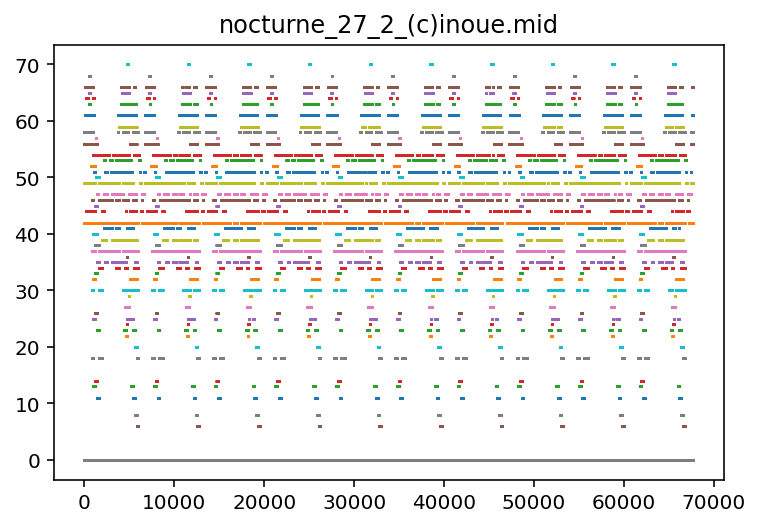

In [564]:
result_array = mid2arry(mid)
import matplotlib.pyplot as plt
plt.plot(range(result_array.shape[0]), np.multiply(np.where(result_array>0, 1, 0), range(1, 89)), marker='.', markersize=1, linestyle='')
plt.title("nocturne_27_2_(c)inoue.mid")
plt.show()

In [581]:
def arry2mid(ary, tempo=500000):
    # get the difference
    new_ary = np.concatenate([np.array([[0] * 88]), np.array(ary)], axis=0)
    changes = new_ary[1:] - new_ary[:-1]
    # create a midi file with an empty track
    mid_new = mido.MidiFile()
    track = mido.MidiTrack()
    mid_new.tracks.append(track)
    track.append(mido.MetaMessage('set_tempo', tempo=tempo, time=0))
    # add difference in the empty track
    last_time = 0
    for ch in changes:
        if set(ch) == {0}:  # no change
            last_time += 1
        else:
            on_notes = np.where(ch > 0)[0]
            on_notes_vol = ch[on_notes]
            off_notes = np.where(ch < 0)[0]
            first_ = True
            for n, v in zip(on_notes, on_notes_vol):
                new_time = last_time if first_ else 0
                track.append(mido.Message('note_on', note=n + 21, velocity=v, time=new_time))
                first_ = False
            for n in off_notes:
                new_time = last_time if first_ else 0
                track.append(mido.Message('note_off', note=n + 21, velocity=0, time=new_time))
                first_ = False
            last_time = 0
    return mid_new

In [582]:
mid_new = arry2mid(result_array, 545455)
mid_new.save('mid_new.mid')